# Plot the comparison between the waveforms and spectra of two different templates on multiple stations

In [115]:
# Import modules
from matplotlib.pyplot import subplots
from matplotlib import ticker
from obspy import read, UTCDateTime
from utils_snuffler import read_normal_markers
from utils_preproc import read_and_process_windowed_waveforms
from utils_spec import get_data_spectrum, get_filter_response, get_data_psd
from utils_cc import get_timewin_from_template_name
from pandas import DataFrame
from os.path import join
from numpy import amax, abs

In [116]:
# Inputs
## Parameters for reading and processing
name1 = "TwinA12-17-23-38"
name2 = "TwinB16-08-06-34"

rootdir = "/Volumes/OmanData/geophones_no_prefilt/data"
phase = "X"
component = "Z"

stadict = {"template1": ["A04", "A06", "A03", "A02", "A01"], "template2": ["B04", "B06", "B03", "B02", "B01"]}

freqmin_filt = 10
freqmax_filt = 450

begin = -0.025
end = 0.3

## Parameters for plotting
plot_reference = True # Plot reference frequencies or not
reffreqs = [85.0, 105.0]

freqmin_plot = 10

psdmin = 1e-2

linewidth = 2.0

In [117]:
# Read the snuffler pick files
timewin1 = get_timewin_from_template_name(name1)
timewin2 = get_timewin_from_template_name(name2)

pickdf1 = read_normal_markers(join(rootdir, timewin1, f"{phase.lower()}picks_{name1}.dat"))
pickdf2 = read_normal_markers(join(rootdir, timewin2, f"{phase.lower()}picks_{name2}.dat"))

In [118]:
# Read and process the waveform
stream1 = read_and_process_windowed_waveforms(pickdf1, freqmin_filt, freqmax_filt, begin=begin, end=end, reference="individual")
stream2 = read_and_process_windowed_waveforms(pickdf2, freqmin_filt, freqmax_filt, begin=begin, end=end, reference="individual")

A04
A03
A02
A06
A05
A01
B04
B06
B02
B01
B03


Figure saved to /Volumes/OmanData/geophones_no_prefilt/data/template_compare_TwinA12-17-23-38_TwinB16-08-06-34.png


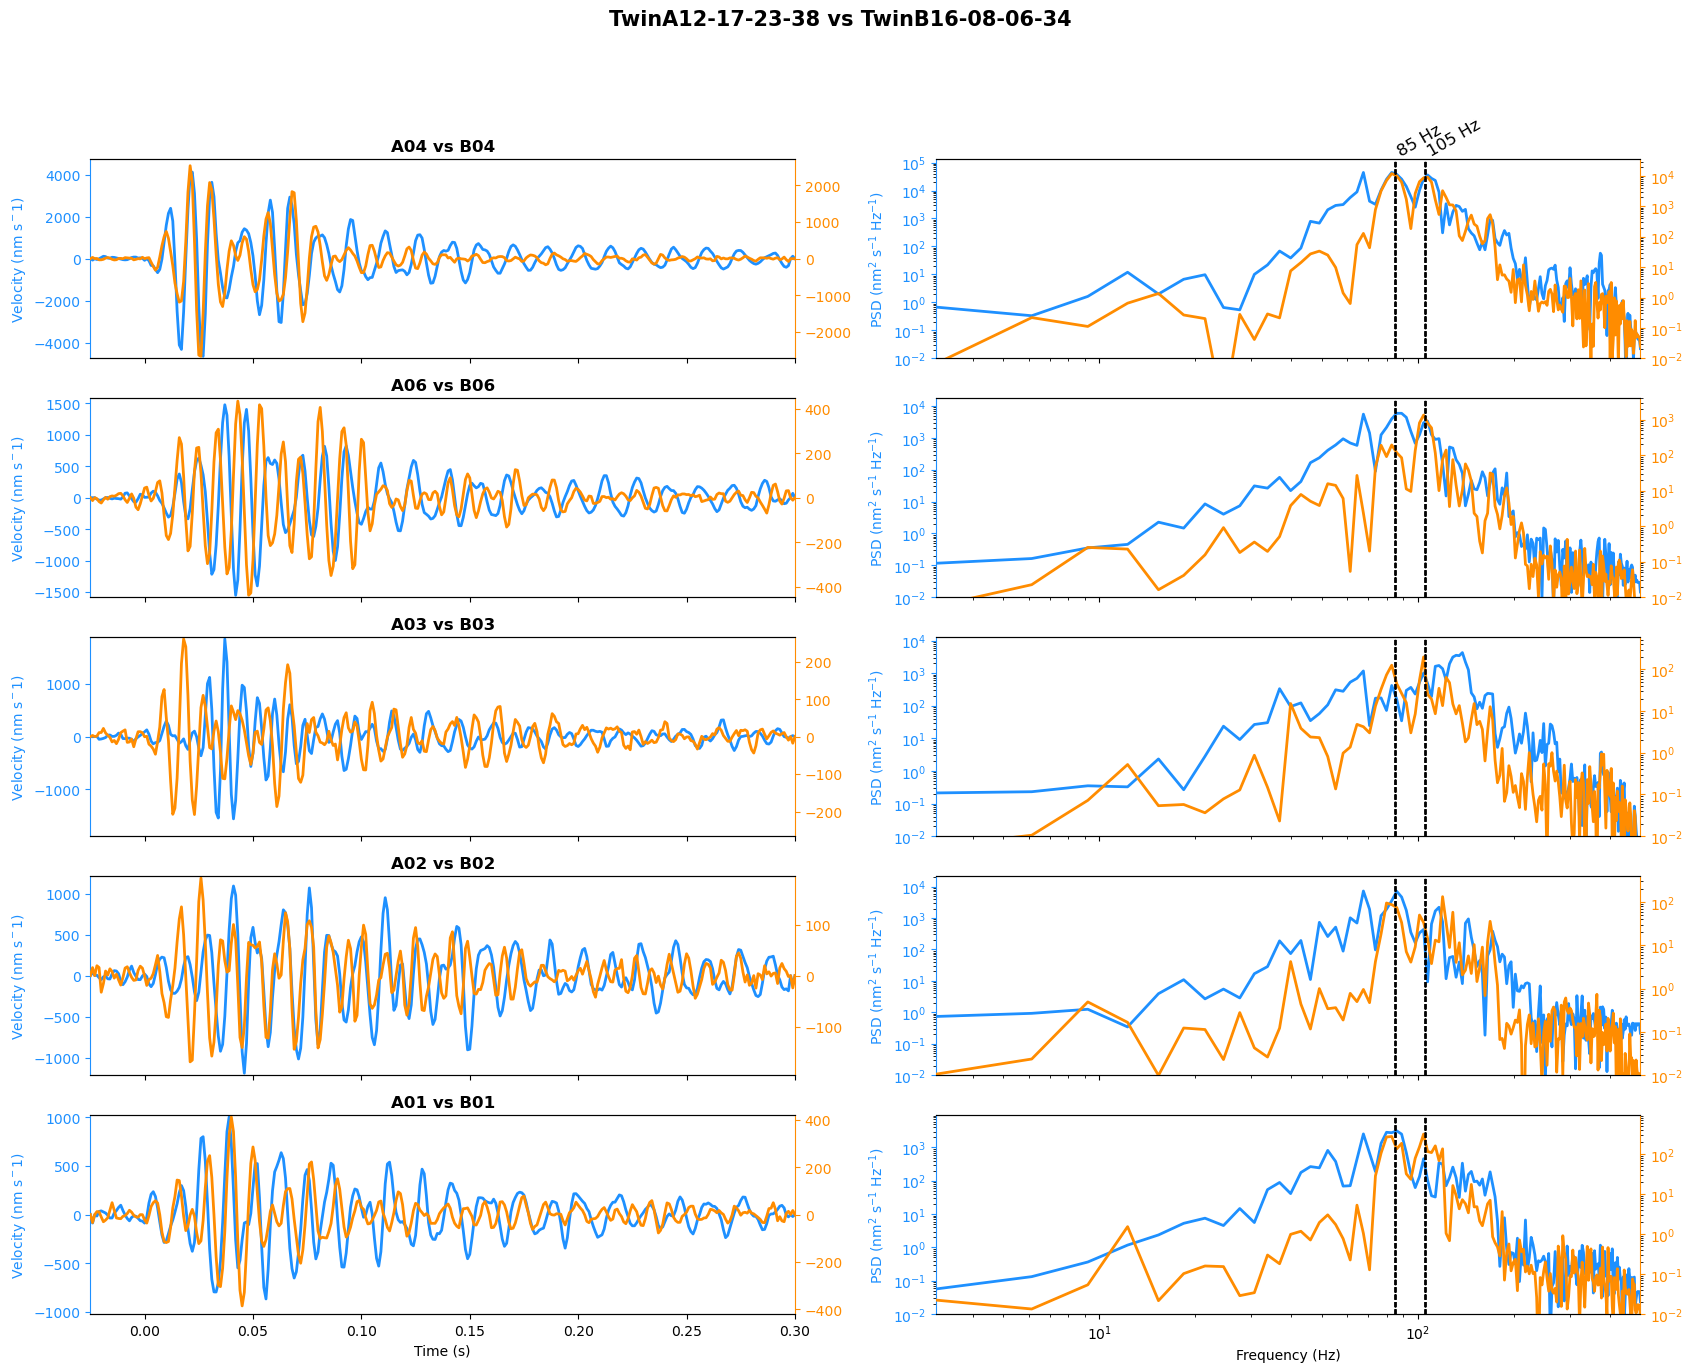

In [121]:
# Define the subplots
stadf = DataFrame(stadict)
numst = len(stadf)

fig, axes = subplots(nrows=numst, ncols=2, figsize=(20, 15))

# Plot the waveforms and spectra
for i, row in stadf.iterrows():

    ## Plot the waveforms
    station1 = row["template1"]
    station2 = row["template2"]

    trace1 = stream1.select(station=station1, component=component)[0]
    trace2 = stream2.select(station=station2, component=component)[0]

    data1 = trace1.data
    data2 = trace2.data

    timeax1 = trace1.times()+begin
    timeax2 = trace2.times()+begin

    ax_wave1 = axes[i, 0]
    ax_wave2 = ax_wave1.twinx()

    ax_wave1.plot(timeax1, data1, color="dodgerblue", label="A", linewidth=linewidth)
    ax_wave2.plot(timeax2, data2, color="darkorange", label="B", linewidth=linewidth)

    amp1 = amax(abs(data1))
    amp2 = amax(abs(data2))

    ax_wave1.set_ylim(-1.02*amp1, 1.02*amp1)
    ax_wave2.set_ylim(-1.02*amp2, 1.02*amp2)

    ax_wave1.set_xlim(begin, end)

    ax_wave1.spines['left'].set_color('dodgerblue')
    ax_wave1.spines['right'].set_color(None)
    ax_wave2.spines['right'].set_color('darkorange')
    ax_wave2.spines['left'].set_color(None)

    ax_wave1.tick_params(axis='y', colors='dodgerblue')
    ax_wave2.tick_params(axis='y', colors='darkorange')

    ax_wave1.set_ylabel("Velocity (nm s$^-1$)", color="dodgerblue")

    ax_wave1.set_title(f"{station1} vs {station2}", fontweight="bold")

    ## Plot the spectra
    samprat1 = trace1.stats.sampling_rate
    samprat2 = trace2.stats.sampling_rate

    freqax1, psd1 = get_data_psd(data1, samprat1)
    freqax2, psd2 = get_data_psd(data2, samprat2)

    psdmax1 = amax(psd1)
    psdmax2 = amax(psd2)

    ax_psd1 = axes[i, 1]
    ax_psd2 = ax_psd1.twinx()
    ax_psd1.plot(freqax1, psd1, color="dodgerblue", linewidth=linewidth)
    ax_psd2.plot(freqax2, psd2, color="darkorange", linewidth=linewidth)

    ax_psd1.set_xscale('log')
    ax_psd1.set_yscale('log')
    ax_psd1.set_xlim(freqax1[1], freqax1[-1])
    ax_psd1.set_ylim(psdmin, 3.0*psdmax1)

    ax_psd2.set_xscale('log')
    ax_psd2.set_yscale('log')
    ax_psd2.set_xlim(freqax2[1], freqax2[-1])
    ax_psd2.set_ylim(psdmin, 3.0*psdmax2)

    ax_psd1.set_ylabel("PSD (nm$^2$ s$^{-1}$ Hz$^{-1}$)", color="dodgerblue")
    ax_psd1.spines['left'].set_color('dodgerblue')
    ax_psd1.spines['right'].set_color(None)
    ax_psd1.tick_params(axis='y', colors='dodgerblue')

    ax_psd2.spines['right'].set_color('darkorange')
    ax_psd2.spines['left'].set_color(None)
    ax_psd2.tick_params(axis='y', colors='darkorange')

    if i < numst-1:
        ax_wave1.set_xticklabels([])
        ax_wave2.set_xticklabels([])
        ax_psd1.set_xticklabels([])
        ax_psd2.set_xticklabels([])
    else:
        ax_wave1.set_xlabel("Time (s)")
        ax_psd1.set_xlabel("Frequency (Hz)")

    ## Plot the reference frequencies
    if plot_reference:
        for ax in  [ax_psd1, ax_psd2]:
            for freq in reffreqs:
                ax.axvline(x=freq, color="black", linestyle="--", linewidth=linewidth/2)
                if plot_reference:
                    for ax in [ax_psd1, ax_psd2]:
                        for freq in reffreqs:
                            ax.axvline(x=freq, color="black", linestyle="--", linewidth=linewidth/2)

## Annotate the reference frequencies in the first spectral plot
if plot_reference:
    for freq in reffreqs:
        psdmax = axes[0, 1].get_ylim()[1]
        axes[0, 1].annotate(f"{freq:.0f} Hz", xy=(freq, psdmax), fontsize=12, ha="left", va="bottom", arrowprops=dict(facecolor="black"), rotation=30)

## Set the supertitle
fig.suptitle(f"{name1} vs {name2}", fontsize=15, fontweight="bold")

# Save the figure 
fig.patch.set_alpha(0.0)

outpath= join(rootdir, f"template_compare_{name1}_{name2}.png")
fig.savefig(outpath, dpi=300)
print(f"Figure saved to {outpath}")